In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import sys
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import mixed_precision
from IPython.display import Audio
import librosa
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
import tensorflow_io as tfio




2022-08-22 16:23:50.377283: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TF_ENABLE_ONEDNN_OPTS=0

In [3]:
sr = 16000
part = '3'
WEIGHT_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/Backing_0_1_data0401_0811_adult_part_'+part+'.npz'
SEED = 42
def plot_time_series(data, sr):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, len(data)/sr, len(data)), data)
    plt.show()


In [4]:
x = np.load(WEIGHT_PATH, mmap_mode='r', allow_pickle=True)
X_train = x['X_train']
y_train = x['y_train']
X_test = x['X_test']
y_test = x['y_test']

In [5]:
classes = np.unique(y_train)
total = len(y_train)
for c in classes:
	n_examples = len(y_train[y_train == c])
	percent = n_examples / total * 100
	print(f'> Class={c} : {n_examples}/{total} {percent}%')

> Class=0 : 318/877 36.259977194982895%
> Class=16 : 559/877 63.740022805017105%


In [6]:
classes = np.unique(y_test)
total = len(y_test)
for c in classes:
	n_examples = len(y_test[y_test == c])
	percent = n_examples / total * 100
	print(f'> Class={c} : {n_examples}/{total} {percent}%')


> Class=0 : 158/438 36.07305936073059%
> Class=16 : 280/438 63.926940639269404%


## change class

In [7]:
for c in classes:
    if c == 0:
        y_train[y_train == c] = 1 
        y_test[y_test == c] = 1 
    elif c == 16:
        y_train[y_train == c] = 0
        y_test[y_test == c] = 0

In [8]:
classes = np.unique(y_train)
total = len(y_train)
for c in classes:
    n_examples = len(y_train[y_train == c])
    percent = n_examples / total * 100
    print(f'> Class={c} : {n_examples}/{total} {percent}%')


> Class=0 : 559/877 63.740022805017105%
> Class=1 : 318/877 36.259977194982895%


In [9]:
classes = np.unique(y_test)
total = len(y_test)
for c in classes:
    n_examples = len(y_test[y_test == c])
    percent = n_examples / total * 100
    print(f'> Class={c} : {n_examples}/{total} {percent}%')


> Class=0 : 280/438 63.926940639269404%
> Class=1 : 158/438 36.07305936073059%


## data augmentation

In [10]:
# minority_data = X_train[y_train == 1]
# minority_label = y_train[y_train == 1]
minority_data = X_train
minority_label = y_train


In [11]:
minority_data.shape


(877, 32000)

In [12]:
minority_label.shape


(877,)

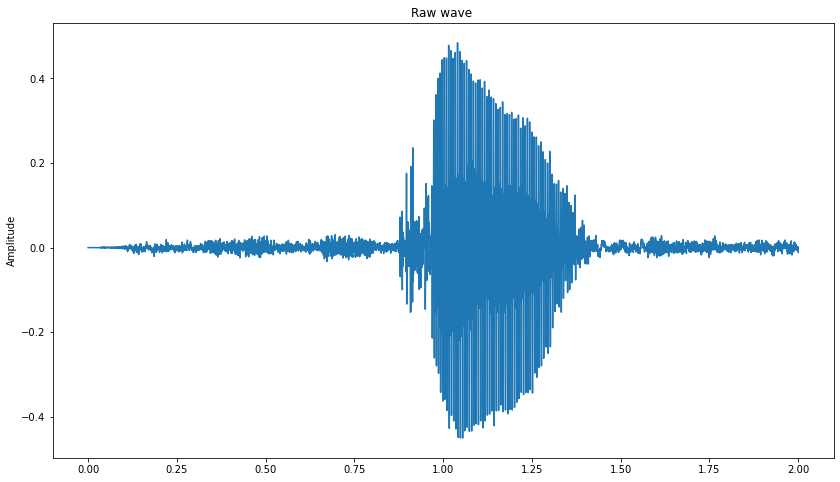

In [13]:
plot_time_series(minority_data[0], sr)
Audio(minority_data[0], rate=sr)

In [14]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment1 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
augment2 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    TimeStretch(min_rate=0.8, max_rate=1.25, p=1)
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

augment3 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
    PitchShift(min_semitones=-4, max_semitones=4, p=1),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=1)
])

augment4 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)
])

# Generate 2 seconds of dummy audio for the sake of example
# samples = np.random.uniform(
#     low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# Augment/transform/perturb the audio data
augmented_sample1 = augment1(samples=minority_data, sample_rate=sr)
augmented_sample2 = augment2(samples=minority_data, sample_rate=sr)
augmented_sample3 = augment3(samples=minority_data, sample_rate=sr)
augmented_sample4 = augment4(samples=minority_data, sample_rate=sr)


In [15]:
print(f"augmented_sample1.shape: {augmented_sample1.shape}")
print(f"augmented_sample2.shape: {augmented_sample2.shape}")
print(f"augmented_sample3.shape: {augmented_sample3.shape}")
print(f"augmented_sample4.shape: {augmented_sample4.shape}")


augmented_sample1.shape: (877, 32000)
augmented_sample2.shape: (877, 32000)
augmented_sample3.shape: (877, 32000)
augmented_sample4.shape: (877, 32000)


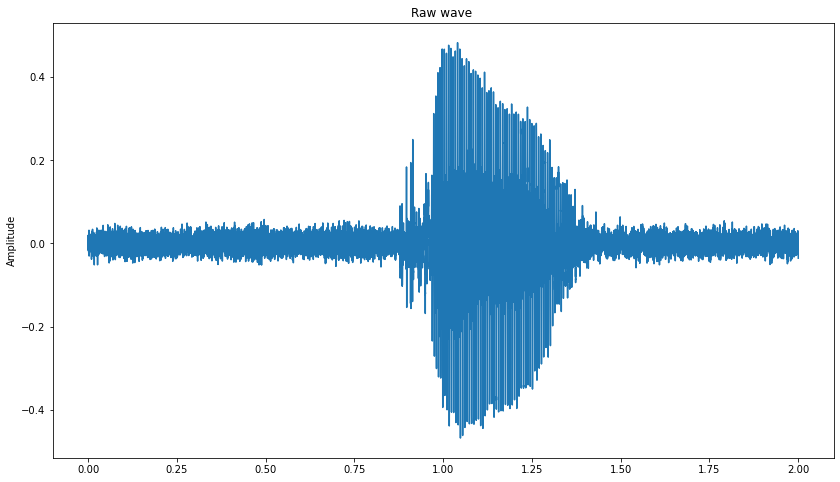

In [16]:
plot_time_series(augmented_sample1[0], sr)
Audio(augmented_sample1[0], rate=sr)

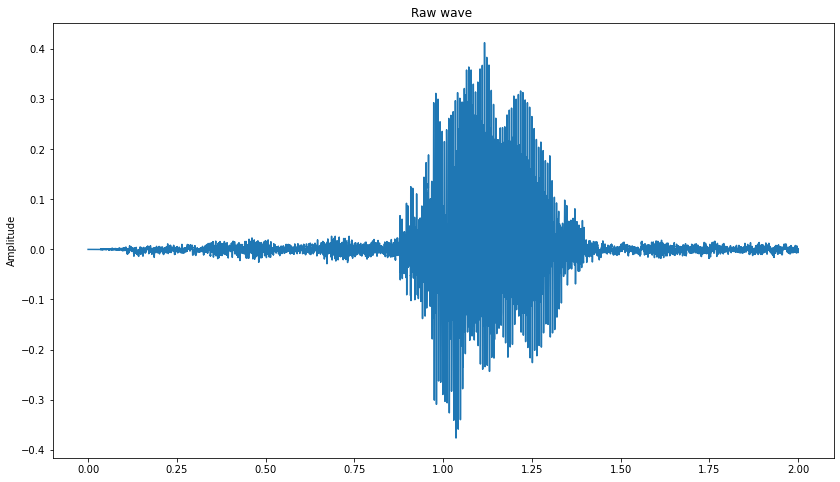

In [17]:
plot_time_series(augmented_sample2[0], sr)
Audio(augmented_sample2[0], rate=sr)


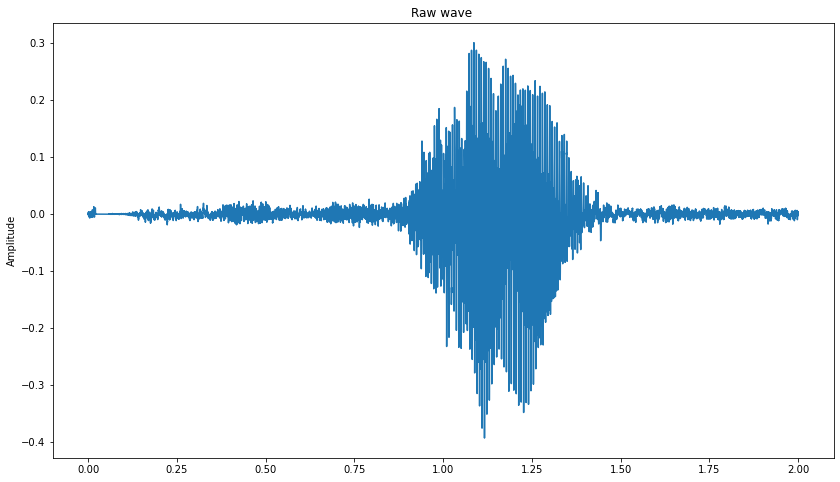

In [18]:
plot_time_series(augmented_sample3[0], sr)
Audio(augmented_sample3[0], rate=sr)

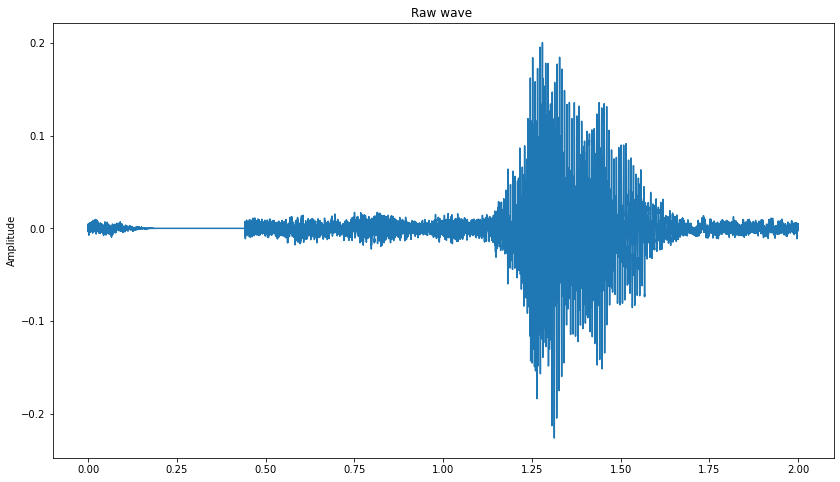

In [19]:
plot_time_series(augmented_sample4[0], sr)
Audio(augmented_sample4[0], rate=sr)

In [20]:
X_train = np.concatenate(
    [X_train, augmented_sample1, augmented_sample2, augmented_sample3, augmented_sample4], axis=0)
y_train = np.concatenate(
    [y_train, minority_label, minority_label, minority_label, minority_label], axis=0)
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")



X_train.shape: (4385, 32000)
y_train.shape: (4385,)


## Random train

In [21]:
order = np.arange(len(y_train))
np.random.seed(SEED)
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
X_train.shape


(4385, 32000)

# Wav2vec2

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import tensorflow as tf
import datetime
import tempfile
import tensorflow_hub as hub


In [23]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [30]:
import tensorflow as tf

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]


# For using this pre-trained model for training, pass `trainable=True` in `hub.KerasLayer`
pretrained_layer = hub.KerasLayer(
    "https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=True)

VOCAB_SIZE = 32


def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # Let's wrap all the layers into `tf.keras.Model` using TensorFlow's Functional API
    inputs = tf.keras.Input(shape=(246000,))
    hidden_states = pretrained_layer(inputs)
    outputs = keras.layers.Dense(
        1, activation='sigmoid', bias_initializer=output_bias)(hidden_states)
    model = keras.Model(inputs, outputs)
    # For using this model, it's important to set `jit_compile=True` on GPUs/CPUs
    # as some operations in this model (i.e. group-convolutions) are unsupported without it
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS)
    return model





In [ ]:
from transformers import Wav2Vec2Processor, TFWav2Vec2Model
from datasets import load_dataset
import soundfile as sf

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = TFWav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")


# def map_to_array(batch):
#     speech, _ = sf.read(batch["file"])
#     batch["speech"] = speech
#     return batch


# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy",
#                   "clean", split="validation")
# ds = ds.map(map_to_array)

input_values = processor(
    ds["speech"][0], return_tensors="tf").input_values  # Batch size 1
hidden_states = model(input_values).last_hidden_state


### Baseline model

In [31]:
EPOCHS = 50
BATCH_SIZE = 32
SAVE_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/weight/'
model_name = 'EfficientNetV2B0'
output_bias = None
dataset = 'Backing-mix-baseline'
NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+part+'_' + \
    datetime.datetime.now().strftime("%m%d_%H%M")
log_dir = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/logs/' + NAME


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_ckpt = ModelCheckpoint(
            SAVE_PATH + NAME +
            '_{epoch:02d}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
            monitor='val_recall',
            mode='max',
            save_freq='epoch',
            verbose=2, 
            save_best_only=True)
es = EarlyStopping(monitor='val_recall', mode='max', verbose=1, restore_best_weights=True, patience=10)
model = make_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 768, 768)          94371712  
                                                                 
 dense (Dense)               (None, 768, 1)            769       
                                                                 
Total params: 94,372,481
Trainable params: 94,372,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


### Train the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        model_ckpt,
        es
    ],
    validation_data=(X_test, y_test))


Epoch 1/50


2022-08-18 21:52:56.642666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-18 21:52:56.793539: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-18 21:52:56.794302: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-18 21:52:56.794320: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-18 21:52:56.794984: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-18 21:52:56.795034: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


286/286 [==============================] - ETA: 0s - loss: 0.4365 - tp: 1806.0000 - fp: 643.0000 - tn: 5557.0000 - fn: 1144.0000 - accuracy: 0.8047 - precision: 0.7374 - recall: 0.6122 - auc: 0.8550 - prc: 0.7511
Epoch 1: val_recall improved from -inf to 0.33333, saving model to /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0817/weight/EfficientNetV2B0_Backing-mix-baseline_bs32_data_part1_0818_2152_01-0.27-0.33.hdf5
286/286 [==============================] - 24s 65ms/step - loss: 0.4365 - tp: 1806.0000 - fp: 643.0000 - tn: 5557.0000 - fn: 1144.0000 - accuracy: 0.8047 - precision: 0.7374 - recall: 0.6122 - auc: 0.8550 - prc: 0.7511 - val_loss: 0.8561 - val_tp: 19.0000 - val_fp: 51.0000 - val_tn: 150.0000 - val_fn: 38.0000 - val_accuracy: 0.6550 - val_precision: 0.2714 - val_recall: 0.3333 - val_auc: 0.5646 - val_prc: 0.2561
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 0.2353 - tp: 2477.0000 - fp: 373.0000 - tn: 5827.0000 - fn: 473.0000 - accu